# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

# Load Data

In [2]:
train = pd.read_csv('train_ctrUa4K.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
test = pd.read_csv('test_lAUu6dG.csv')
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [4]:
sub = pd.read_csv('sample_submission_49d68Cx.csv')
sub.head()

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N


# EDA

In [14]:
train.shape

(614, 13)

In [81]:
test.shape

(367, 12)

In [82]:
train.duplicated().sum()

0

# Check Null Values

In [83]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [84]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

# Filling null values

In [5]:
def fill_na(frame):
    for i in frame.columns:
        if(((frame[i].isnull().sum() / len(frame))*100) <= 30) & (frame[i].dtype == 'int64'):
            frame[i] = frame[i].fillna(frame[i].median())
            
        elif(((frame[i].isnull().sum() / len(frame))*100) <= 30) & (frame[i].dtype == 'O'):
            frame[i] = frame[i].fillna(frame[i].mode()[0])
            
        elif(((frame[i].isnull().sum() / len(frame))*100) <= 30) & (frame[i].dtype == 'float64'):
            frame[i] = frame[i].fillna(frame[i].median())
            
fill_na(train)
fill_na(test)

# Check description

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [87]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.50,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.00,1188.5,2297.25,41667.0
LoanAmount,614.0,145.752443,84.107233,9.0,100.25,128.0,164.75,700.0
Loan_Amount_Term,614.0,342.410423,64.428629,12.0,360.00,360.0,360.00,480.0
Credit_History,614.0,0.855049,0.352339,0.0,1.00,1.0,1.00,1.0


# Changing Datatypes

In [6]:
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype('int64')
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype('int64')
train['Credit_History'] = train['Credit_History'].astype('O')
test['Credit_History'] = test['Credit_History'].astype('O')

# Drop Columns

In [7]:
train = train.drop('Loan_ID', axis=1)
test = test.drop('Loan_ID', axis=1)

# EDA

# Univariant Analysis

Gender


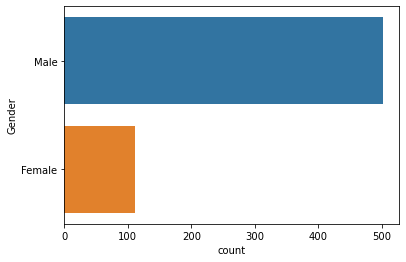

Married


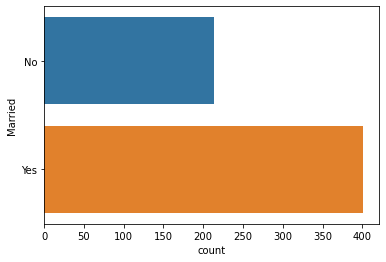

Dependents


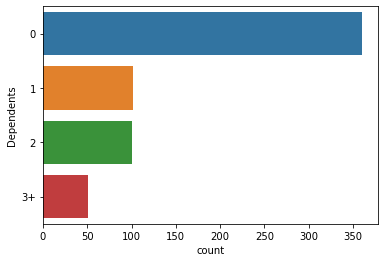

Education


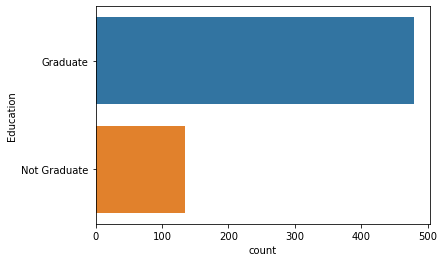

Self_Employed


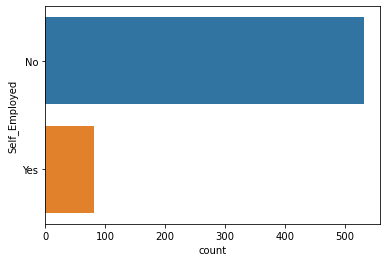

Credit_History


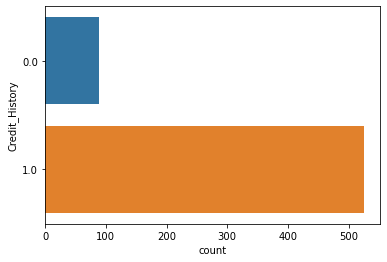

Property_Area


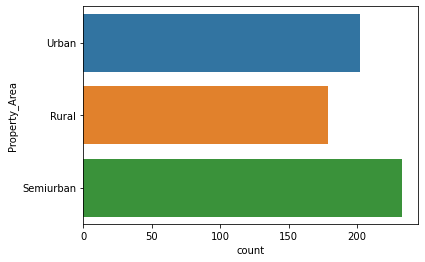

Loan_Status


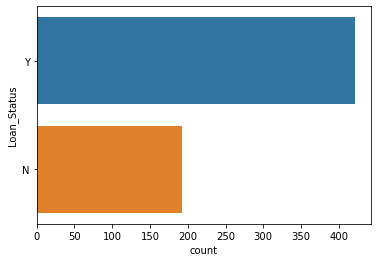

In [8]:
def univariant(frame):
    for i in frame.columns:
        if(frame[i].dtype == 'O'):
            print(i)
            sns.countplot(y=frame[i])
            plt.show()
            
univariant(train)

# BiVariant Analysis

Married VS Gender


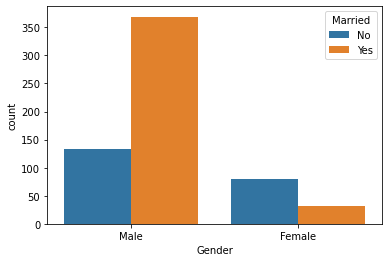

Dependents VS Gender


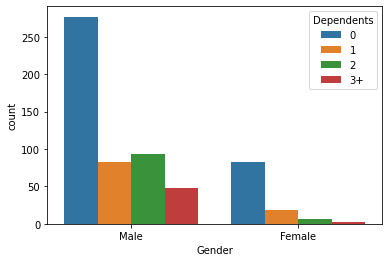

Education VS Gender


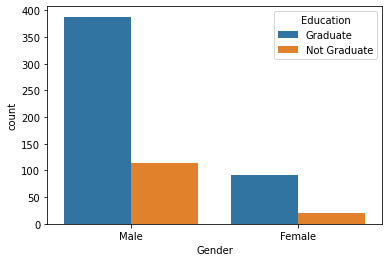

Self_Employed VS Gender


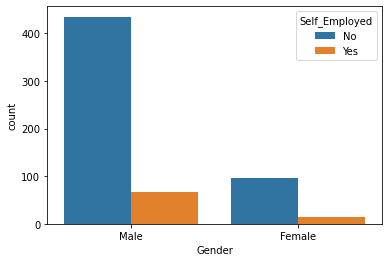

Credit_History VS Gender


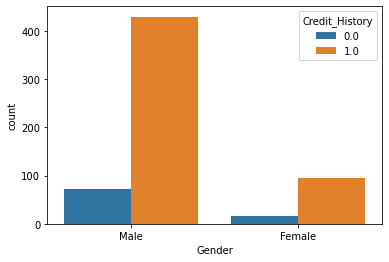

Property_Area VS Gender


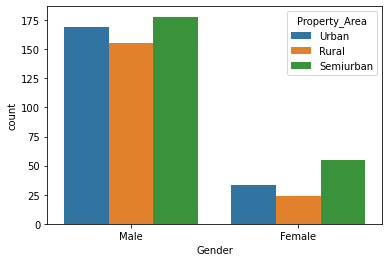

Loan_Status VS Gender


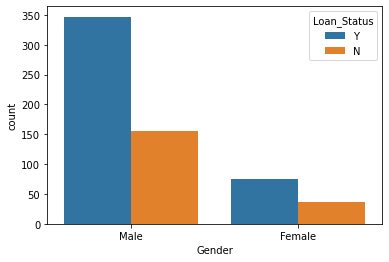

Gender VS Married


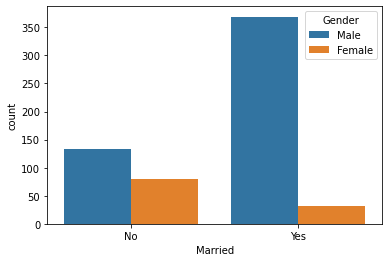

Dependents VS Married


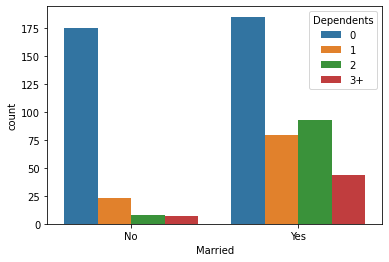

Education VS Married


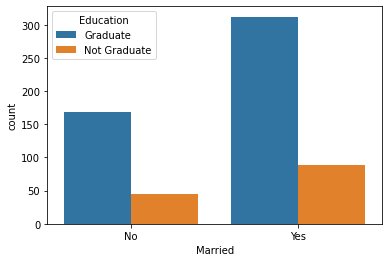

Self_Employed VS Married


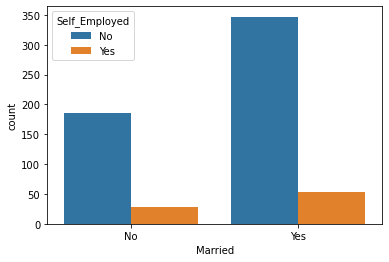

Credit_History VS Married


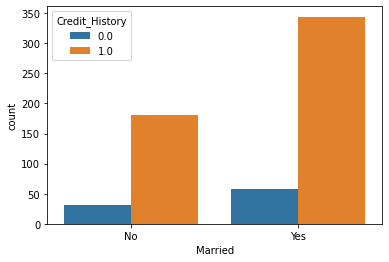

Property_Area VS Married


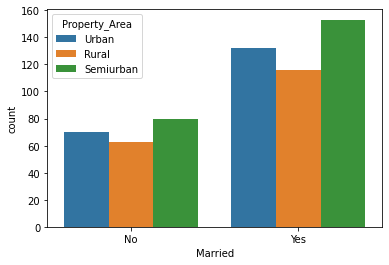

Loan_Status VS Married


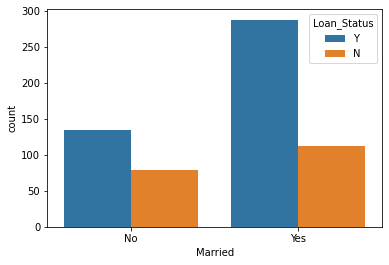

Gender VS Dependents


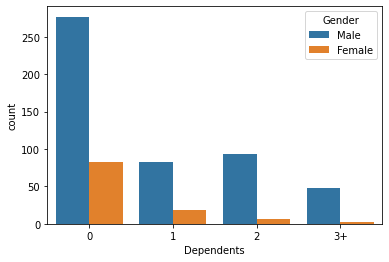

Married VS Dependents


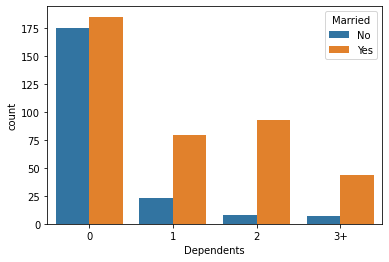

Education VS Dependents


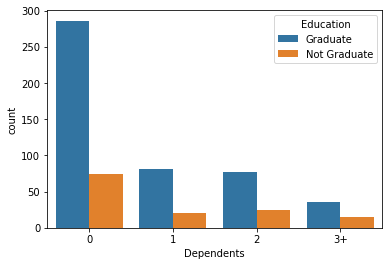

Self_Employed VS Dependents


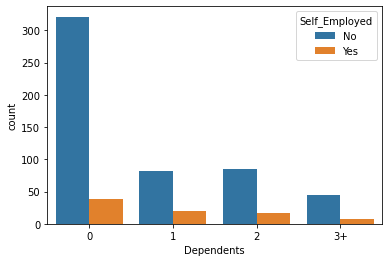

Credit_History VS Dependents


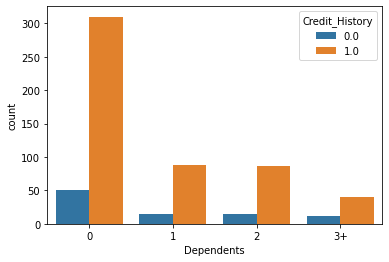

Property_Area VS Dependents


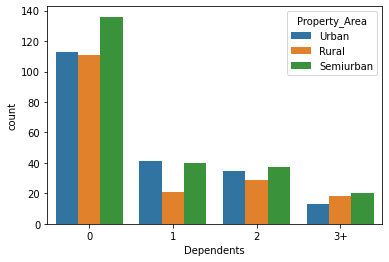

Loan_Status VS Dependents


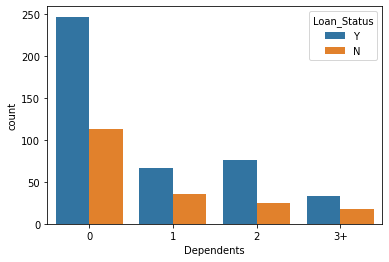

Gender VS Education


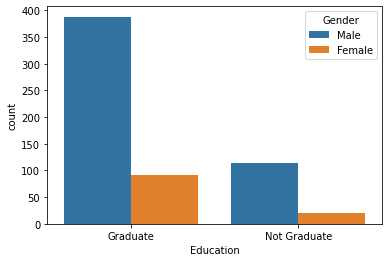

Married VS Education


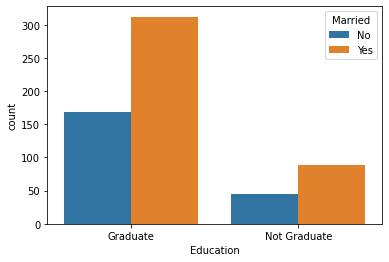

Dependents VS Education


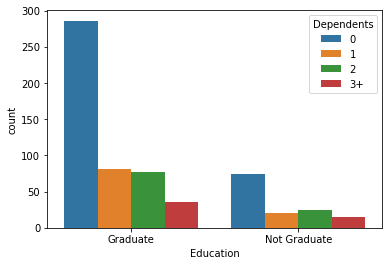

Self_Employed VS Education


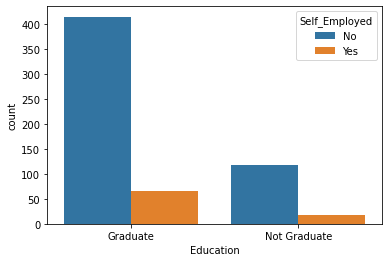

Credit_History VS Education


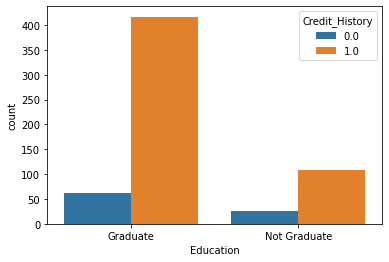

Property_Area VS Education


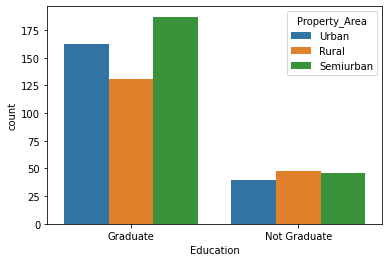

Loan_Status VS Education


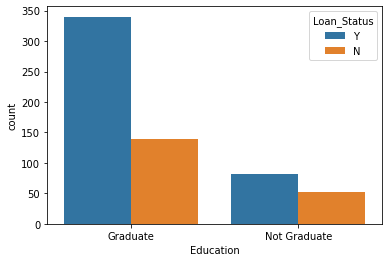

Gender VS Self_Employed


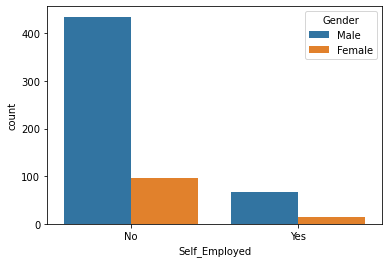

Married VS Self_Employed


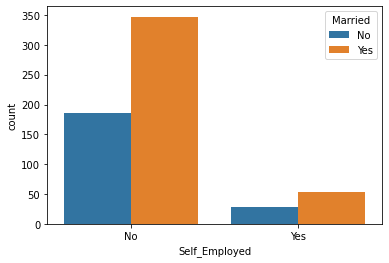

Dependents VS Self_Employed


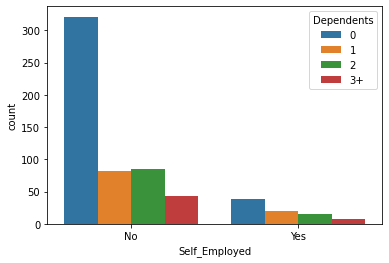

Education VS Self_Employed


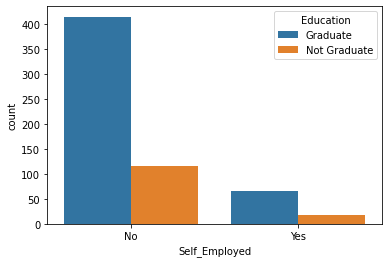

Credit_History VS Self_Employed


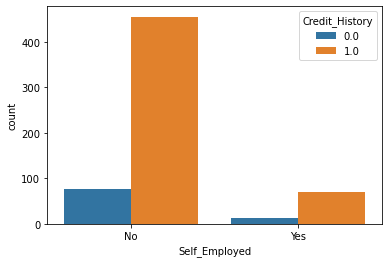

Property_Area VS Self_Employed


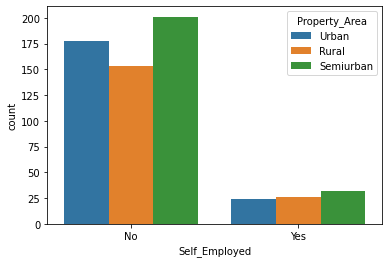

Loan_Status VS Self_Employed


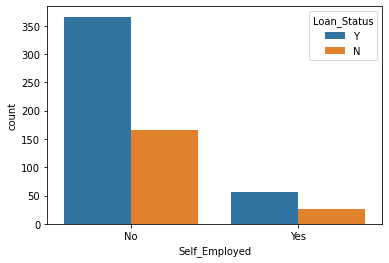

Gender VS Credit_History


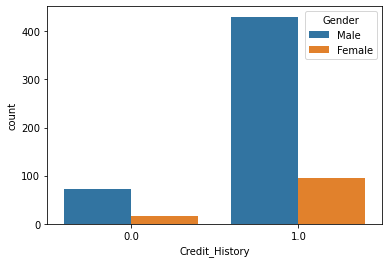

Married VS Credit_History


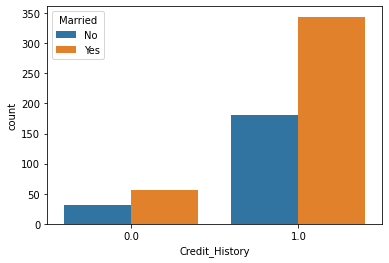

Dependents VS Credit_History


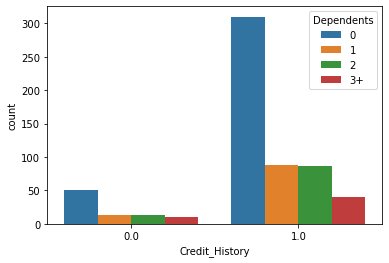

Education VS Credit_History


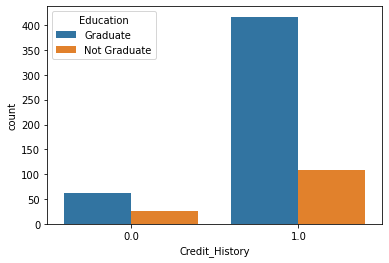

Self_Employed VS Credit_History


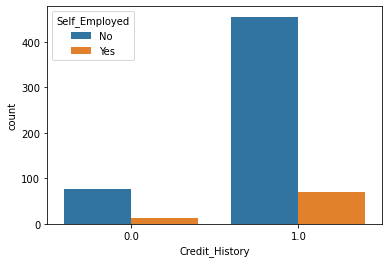

Property_Area VS Credit_History


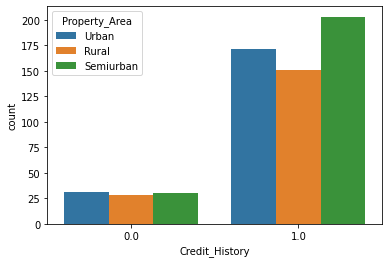

Loan_Status VS Credit_History


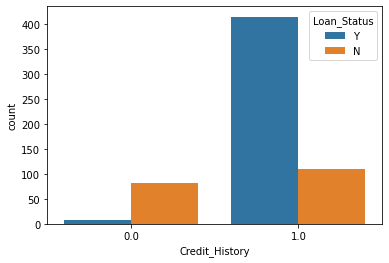

Gender VS Property_Area


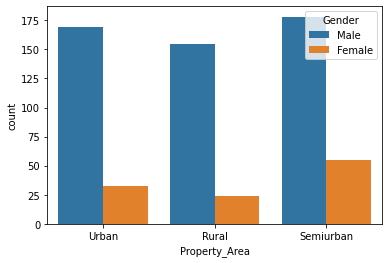

Married VS Property_Area


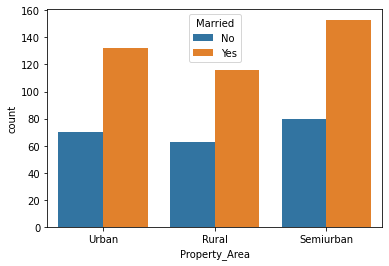

Dependents VS Property_Area


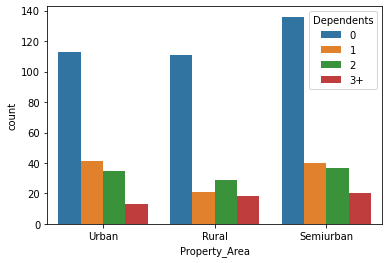

Education VS Property_Area


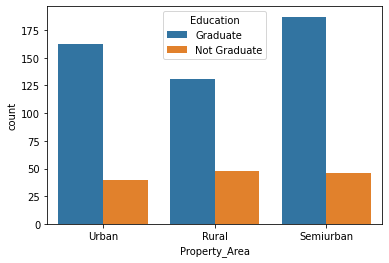

Self_Employed VS Property_Area


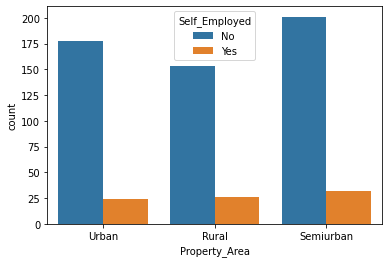

Credit_History VS Property_Area


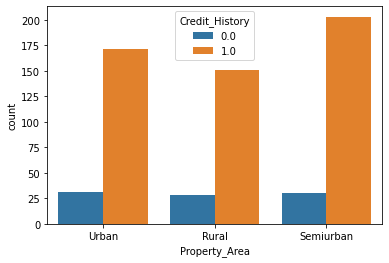

Loan_Status VS Property_Area


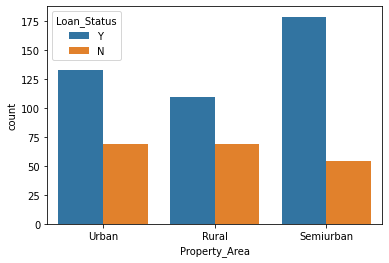

Gender VS Loan_Status


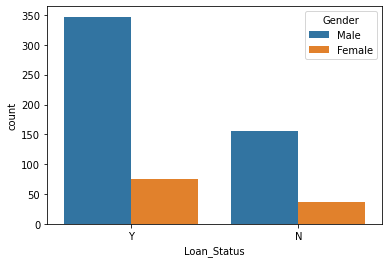

Married VS Loan_Status


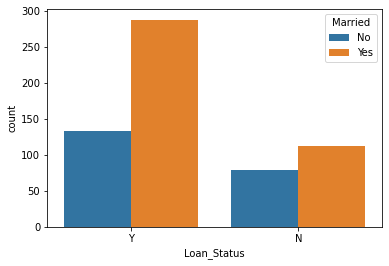

Dependents VS Loan_Status


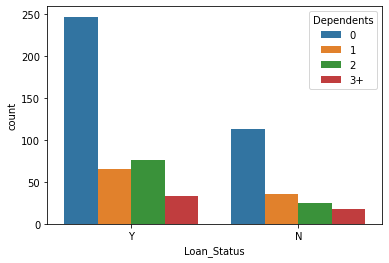

Education VS Loan_Status


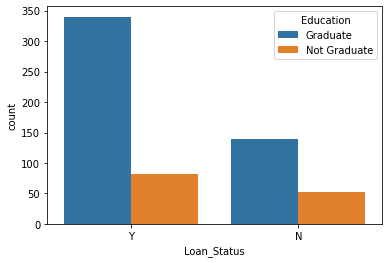

Self_Employed VS Loan_Status


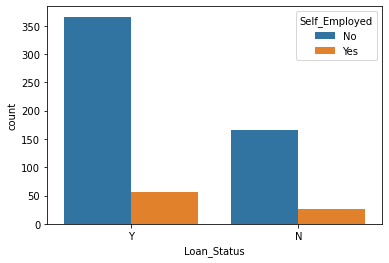

Credit_History VS Loan_Status


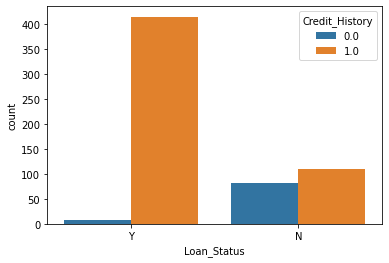

Property_Area VS Loan_Status


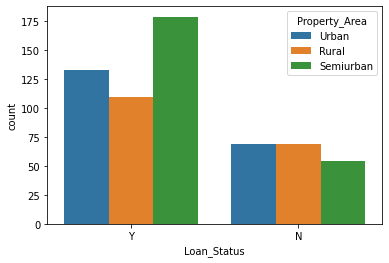

In [10]:
def bivariant(frame):
    for i in frame.columns:
        for j in frame.columns:
            if(i == j):
                pass
            
            elif((frame[i].dtype == 'O') & (frame[j].dtype == 'O')):
                print(j, 'VS', i)
                sns.countplot(hue = frame[j], x= frame[i])
                plt.show()
            
bivariant(train)

# Check Relation with Target variable

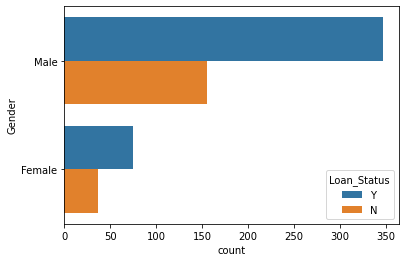

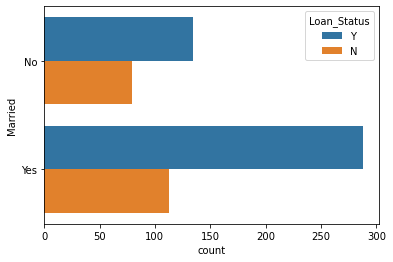

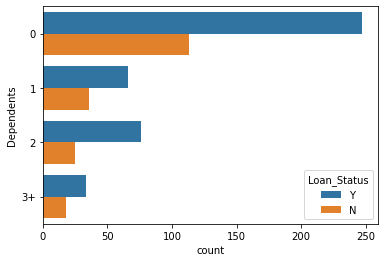

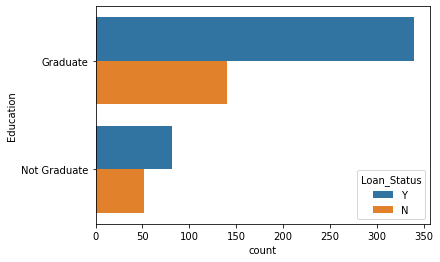

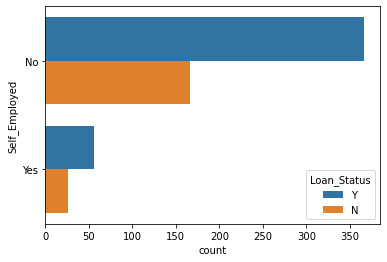

C:\Users\sahil mathur\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


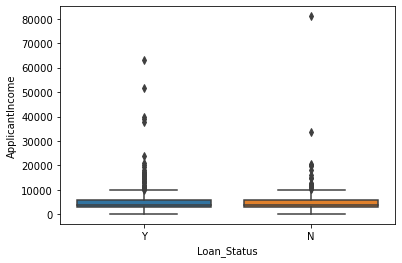

C:\Users\sahil mathur\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


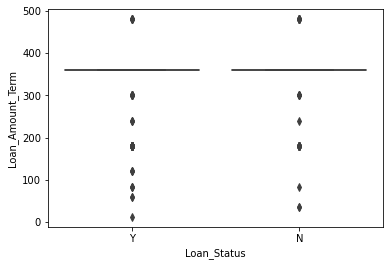

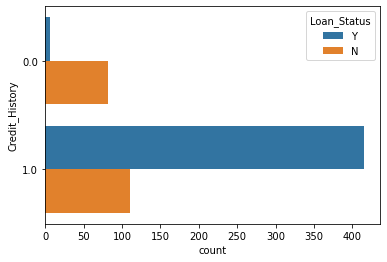

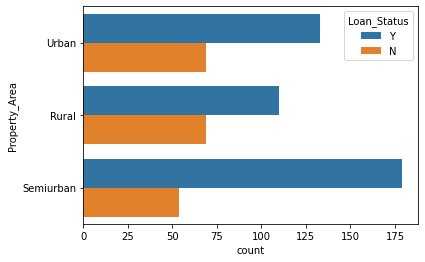

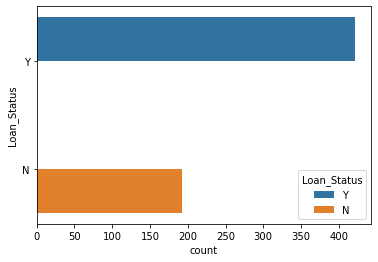

In [11]:
def target(frame):
    for i in frame.columns:
        if(frame[i].dtype == 'int64'):
            sns.boxplot(train['Loan_Status'], frame[i])
            plt.show()
            
        elif(frame[i].dtype == 'O'):
            sns.countplot(hue = train['Loan_Status'], y = frame[i])
            plt.show()
            
target(train)

# MultiVariant Analysis

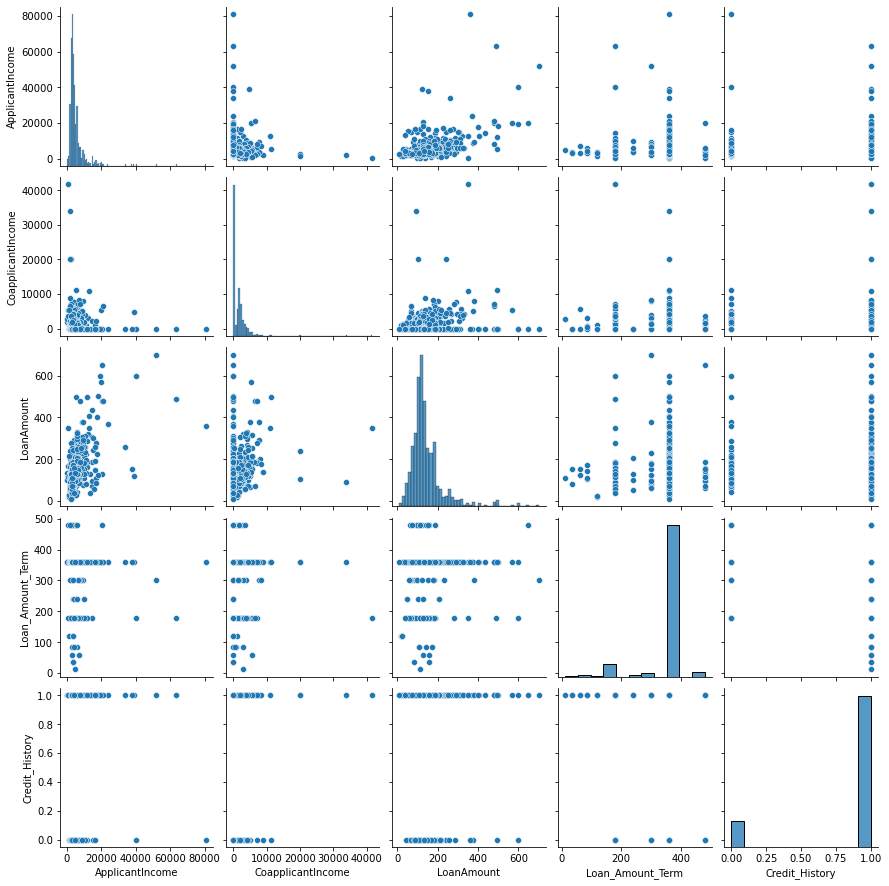

In [12]:
sns.pairplot(train)

# Encode Categorical Features

In [18]:
def encode(dataframe):
    lec = LabelEncoder()
    for j in dataframe.columns:
        if(dataframe[j].dtype == 'object'):
            dataframe[j] = lec.fit_transform(dataframe[j])
            
encode(train)
encode(test)

In [19]:
sc = StandardScaler()
sc.fit_transform(train)

array([[ 0.47234264, -1.37208932, -0.73780632, ...,  0.41173269,
         1.22329839,  0.67451931],
       [ 0.47234264,  0.72881553,  0.25346957, ...,  0.41173269,
        -1.31851281, -1.48253724],
       [ 0.47234264,  0.72881553, -0.73780632, ...,  0.41173269,
         1.22329839,  0.67451931],
       ...,
       [ 0.47234264,  0.72881553,  0.25346957, ...,  0.41173269,
         1.22329839,  0.67451931],
       [ 0.47234264,  0.72881553,  1.24474546, ...,  0.41173269,
         1.22329839,  0.67451931],
       [-2.11710719, -1.37208932, -0.73780632, ..., -2.42876026,
        -0.04760721, -1.48253724]])

# Split Data into train and test

In [20]:
x = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Let's Build Models

# Logistic Regression

In [22]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [23]:
lr_pred = lr.predict(X_test)
print(classification_report(Y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.89      0.41      0.56        61
           1       0.77      0.98      0.86       124

    accuracy                           0.79       185
   macro avg       0.83      0.69      0.71       185
weighted avg       0.81      0.79      0.76       185



# Ada Boost Classifier

In [24]:
ada = AdaBoostClassifier()
ada.fit(X_train, Y_train)

AdaBoostClassifier()

In [25]:
ada_pred = ada.predict(X_test)
print(classification_report(Y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.75      0.44      0.56        61
           1       0.77      0.93      0.84       124

    accuracy                           0.77       185
   macro avg       0.76      0.69      0.70       185
weighted avg       0.76      0.77      0.75       185



# Random Forest Classifier

In [26]:
rf = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       n_estimators=400)
rf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       n_estimators=400)

In [27]:
rf_pred = rf.predict(X_test)
print(classification_report(Y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.89      0.39      0.55        61
           1       0.77      0.98      0.86       124

    accuracy                           0.78       185
   macro avg       0.83      0.68      0.70       185
weighted avg       0.81      0.78      0.76       185



In [28]:
accuracy_score(Y_test, rf_pred)

0.7837837837837838

# XGBoost Classifier

In [91]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='ginni',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, max_features='sqrt',
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb.fit(X_train, Y_train)

[22:39:39] WARNING: ..\src\learner.cc:541: 
Parameters: { criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:39:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sahil mathur\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='ginni',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, max_features='sqrt',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
xgb_pred = xgb.predict(X_test)
print(classification_report(Y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        61
           1       0.76      0.94      0.84       124

    accuracy                           0.77       185
   macro avg       0.77      0.68      0.69       185
weighted avg       0.77      0.77      0.74       185



# SVC

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train, Y_train)

In [145]:
svc_pred = svc.predict(X_test)
print(classification_report(Y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.92      0.39      0.55        61
           1       0.77      0.98      0.86       124

    accuracy                           0.79       185
   macro avg       0.85      0.69      0.71       185
weighted avg       0.82      0.79      0.76       185



# SMOTE

In [30]:
smote = SMOTETomek()
x_train, y_train = smote.fit_resample(X_train, Y_train)

In [31]:
ssvc = SVC(kernel='linear')
ssvc.fit(x_train, y_train)

SVC(kernel='linear')

In [32]:
ssvc_pred = ssvc.predict(X_test)
print(classification_report(Y_test, ssvc_pred))

              precision    recall  f1-score   support

           0       0.69      0.48      0.56        61
           1       0.78      0.90      0.83       124

    accuracy                           0.76       185
   macro avg       0.73      0.69      0.70       185
weighted avg       0.75      0.76      0.74       185



# Over Sampling

In [33]:
os = RandomOverSampler(0.3)
x_Train, y_Train = smote.fit_resample(X_train, Y_train)

C:\Users\sahil mathur\anaconda\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=0.3 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [35]:
osvc = SVC(kernel='linear')
osvc.fit(x_Train, y_Train)

SVC(kernel='linear')

In [36]:
osvc_pred = osvc.predict(X_test)
print(classification_report(Y_test, osvc_pred))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56        61
           1       0.78      0.81      0.79       124

    accuracy                           0.72       185
   macro avg       0.68      0.67      0.68       185
weighted avg       0.71      0.72      0.72       185



# KNN

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [28]:
knn_pred = knn.predict(X_test)
print(classification_report(Y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.39      0.18      0.25        61
           1       0.68      0.86      0.76       124

    accuracy                           0.64       185
   macro avg       0.54      0.52      0.50       185
weighted avg       0.59      0.64      0.59       185



In [142]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

GradientBoostingClassifier()

In [143]:
gb_pred = gb.predict(X_test)
print(classification_report(Y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.82      0.44      0.57        61
           1       0.78      0.95      0.86       124

    accuracy                           0.78       185
   macro avg       0.80      0.70      0.71       185
weighted avg       0.79      0.78      0.76       185



# Stacking Classifier

In [130]:
estimators = [
    ('lr' , LogisticRegression(max_iter = 1000)),
    ('xgb', XGBClassifier()),
    ('rf' , RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       n_estimators=400)),
    ('ada' , AdaBoostClassifier())
]

stack = StackingClassifier(estimators=estimators)
stack.fit(X_train, Y_train)

C:\Users\sahil mathur\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sahil mathur\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constra

In [131]:
stack_pred = stack.predict(X_test)
print(classification_report(Y_test, stack_pred))

              precision    recall  f1-score   support

           0       0.93      0.41      0.57        61
           1       0.77      0.98      0.87       124

    accuracy                           0.79       185
   macro avg       0.85      0.70      0.72       185
weighted avg       0.82      0.79      0.77       185



In [132]:
accuracy_score(Y_test, stack_pred)

0.7945945945945946

# Submission File

In [138]:
test['Loan_Status2'] = stack.predict(test)

In [ ]:
listt = list(test['Loan_Status2'])
convertt = []
for c in listt:
    if(c == 1):
        convertt.append('Y')
    else:
        convertt.append('N')
test['Loan_Status'] = convertt

In [ ]:
test = test.drop('Loan_Status2', axis=1)

In [140]:
submit = pd.DataFrame({
    'Loan_ID' : sub['Loan_ID'],
    'Loan_Status' : test['Loan_Status']
})
submit.to_csv('Submition.csv', index=False)

In [134]:
test = test.drop('Loan_Status', axis=1)

# Hyper Parameter Tuning

In [35]:
grid = {
    'n_estimators' : [200, 400, 600, 800, 1000],
    'criterion' : ['ginni', 'entropy'],
    'max_depth' : [1, 2, 3, 4, 5],
    'max_features' : ['auto', 'sqrt', 'log2']
}

In [36]:
random_cv = RandomizedSearchCV(rf,
                              grid,
                              cv=5,
                              n_iter=50,
                              n_jobs=-1,
                              scoring='accuracy',
                              random_state=1,
                              verbose=5)

In [37]:
random_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['ginni', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=1, scoring='accuracy', verbose=5)

In [38]:
random_cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       n_estimators=400)

# Best model

My best model is SVC